In [1]:
%matplotlib inline
import cPickle as pickle
from __future__ import division, print_function
from datetime import datetime, date
import pandas as pd
import numpy as np
import scipy.stats
import logging
import matplotlib.pyplot as plt
from collections import OrderedDict
# logging.basicConfig(level=logging.INFO)

from factor_analytics import quantile_portfolios, portfolio_returns
from data_transform import prepend_index_returns
from visualization import pretty_resample_mean

import seaborn as sns
sns.set()

In [2]:
plt.rcParams["figure.figsize"] = (18,10)

In [3]:
with open('russell_prices_with_delisting.pkl', 'rb') as f:
    prices = pickle.load(f)

In [4]:
with open('book_to_px.pkl', 'rb') as f:
    exposures = pickle.load(f)

In [5]:
with open('russell_index.pkl', 'rb') as f:
    index_prices = pickle.load(f)

In [6]:
market_rets_1day = prepend_index_returns(index_prices['IWB US Equity'],
                                         index_prices['RIY Index']).pct_change(1).iloc[1:]

In [7]:
def excess_returns(portfolio_returns, market_returns):
    assert(portfolio_returns.index.isin(market_returns.index).all())
    return (portfolio_returns - market_returns)[portfolio_returns.index]

In [8]:
rets_1day = prices.pct_change(1).iloc[1:]

In [9]:
decile_portfolios = OrderedDict()

In [10]:
%%time
decile_portfolios[1] = quantile_portfolios(exposures, cuts=10)

CPU times: user 1min 55s, sys: 640 ms, total: 1min 56s
Wall time: 1min 56s


In [11]:
market_rets_1day_eq = portfolio_returns(sum(decile_portfolios[1])/10., rets_1day)

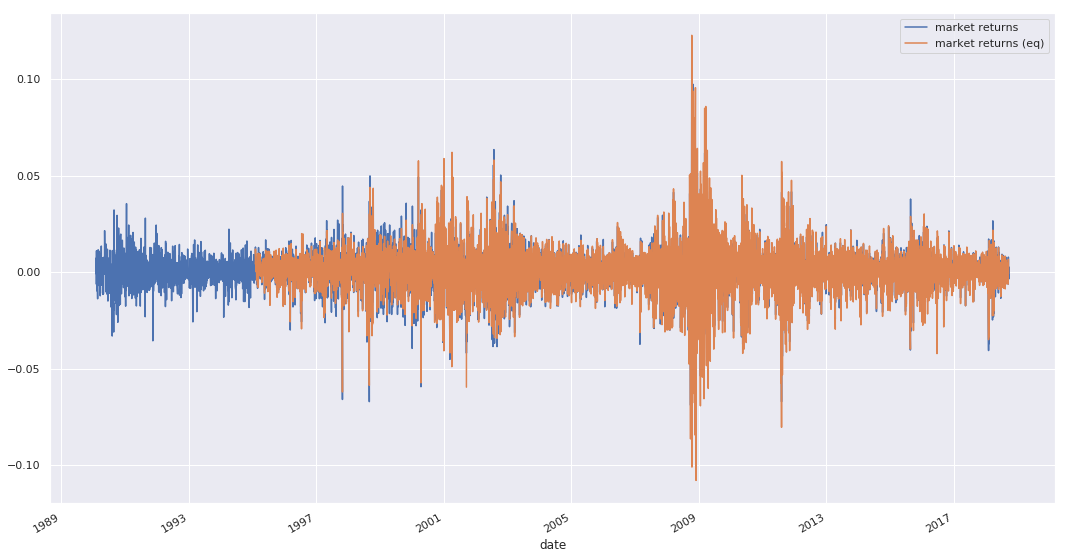

In [12]:
pd.concat({'market returns': market_rets_1day, 'market returns (eq)': market_rets_1day_eq}, axis=1).plot()

In [13]:
long_rets  = portfolio_returns(decile_portfolios[1][9], rets_1day)
short_rets = portfolio_returns(decile_portfolios[1][0], rets_1day)

### Long side

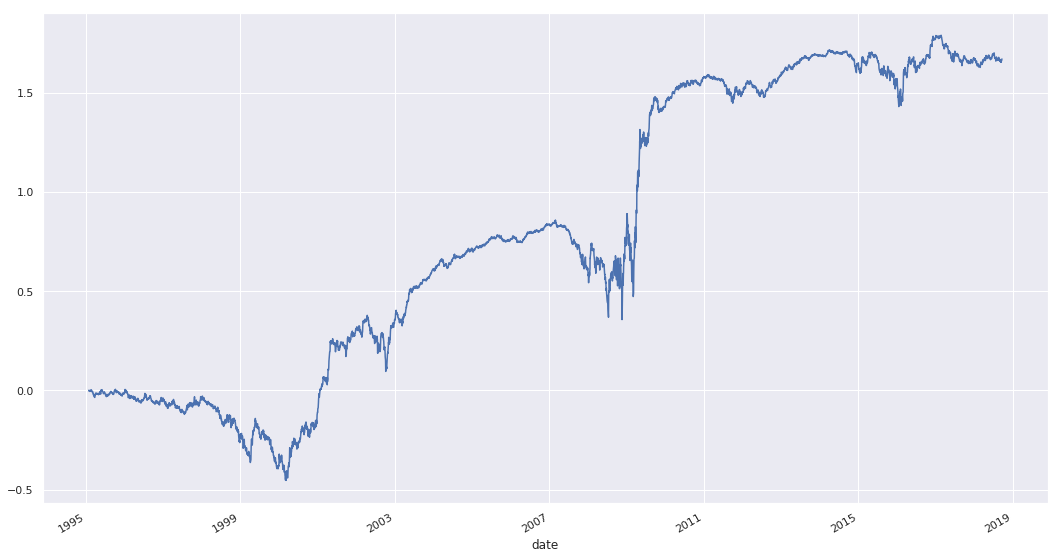

In [14]:
np.log1p(excess_returns(long_rets, market_rets_1day)).cumsum().plot()

### Short side

In [15]:
np.log1p(excess_returns(short_rets, market_rets_1day)).cumsum().plot()

#### Long/short

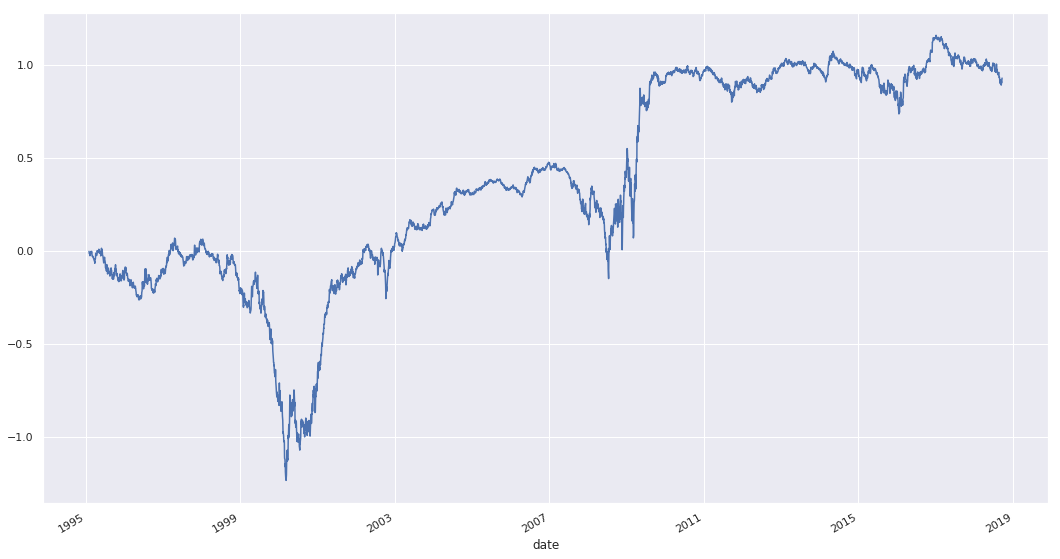

In [16]:
np.log1p(excess_returns(long_rets, short_rets)).cumsum().plot()

### All deciles

In [17]:
decile_returns = pd.concat({quantile: 
   (excess_returns(portfolio_returns(decile_portfolios[1][quantile], rets_1day), market_rets_1day_eq))
   for quantile in range(10)}, axis=1)

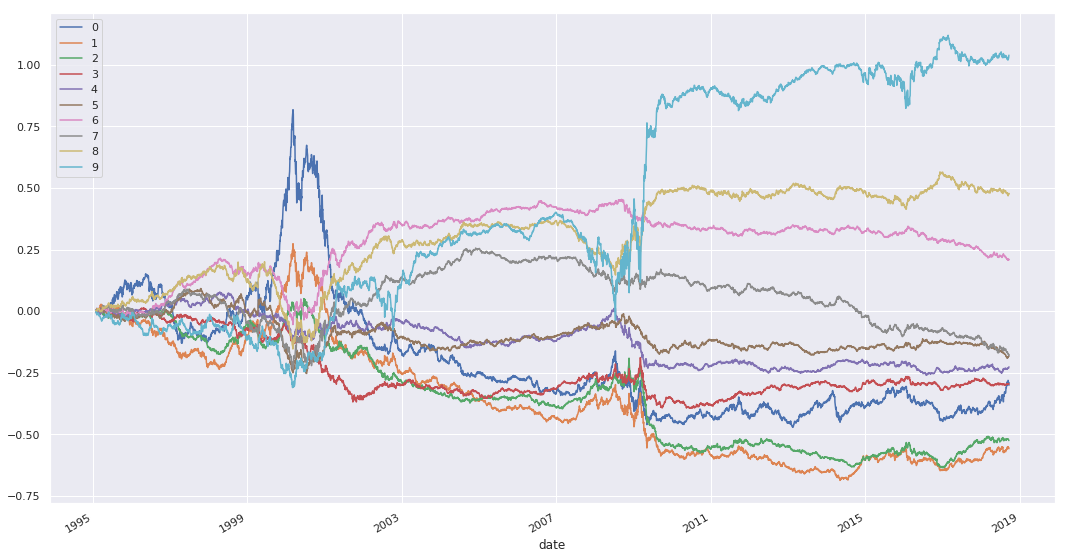

In [18]:
np.log1p(decile_returns).cumsum().plot()

In [19]:
lags = [1, 21, 63, 126] #[5,252]

In [20]:
for lag in lags[1:]:
    decile_portfolios[lag] = [decile_portfolios[1][i].rolling(lag).mean().iloc[lag:] for i in range(10)]

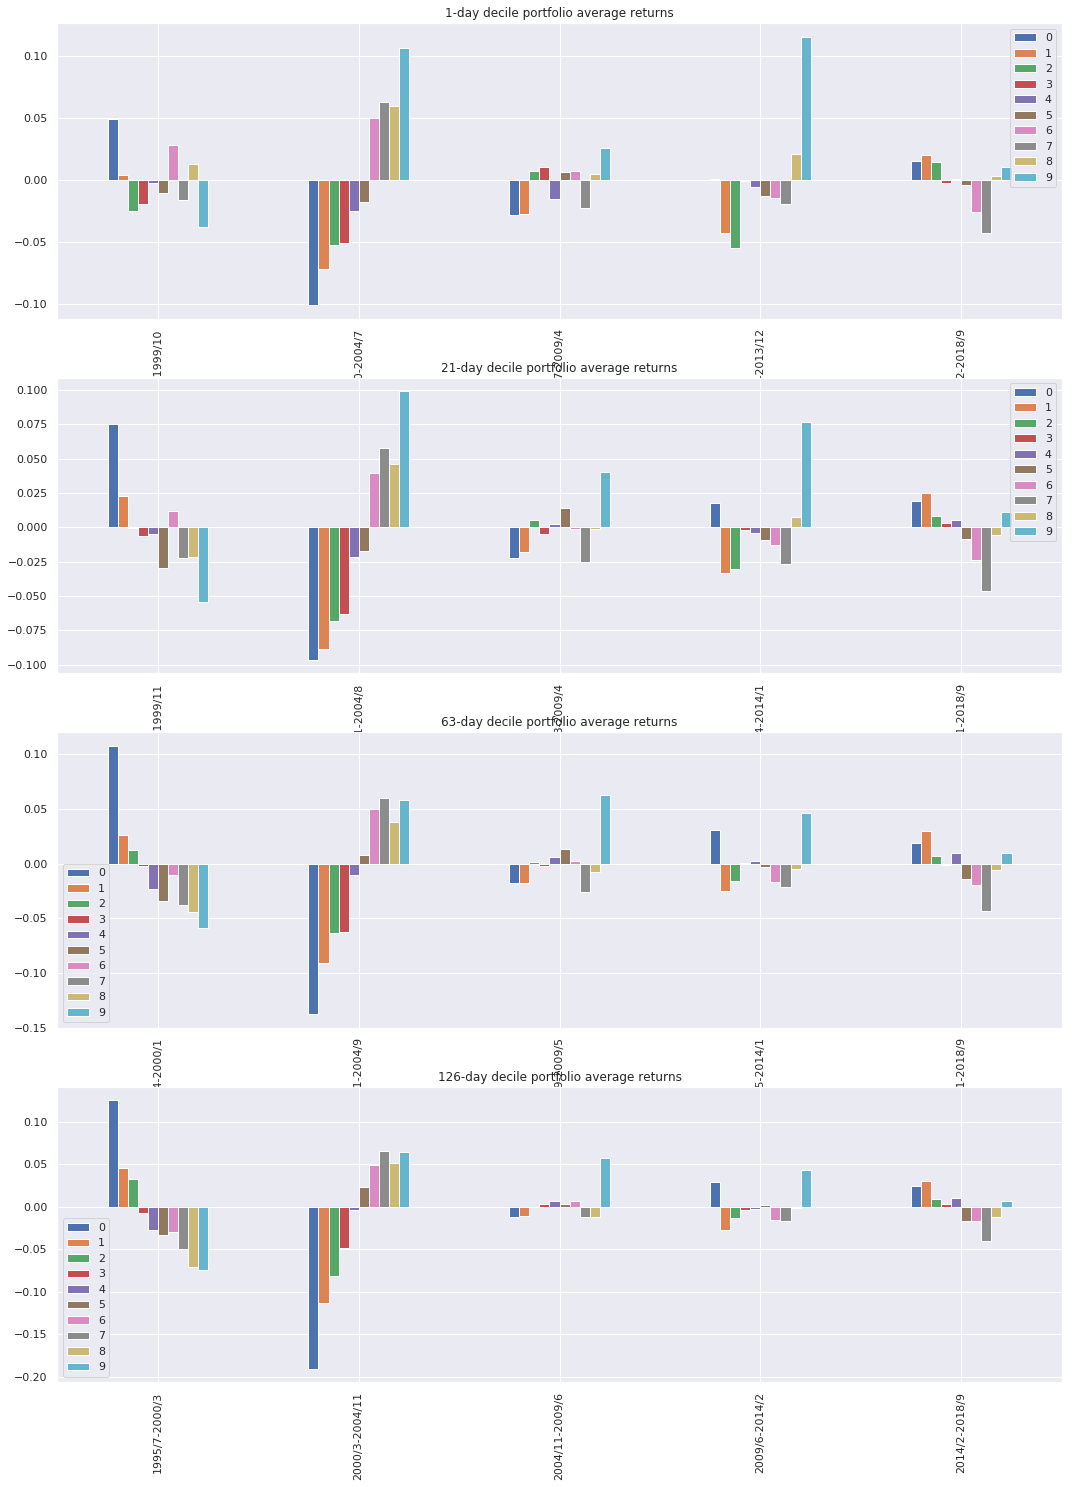

In [21]:
f, axes = plt.subplots(len(lags), 1, sharey=False, figsize=(18,25))
for lag, ax in zip(lags, axes):
    ax.tick_params(axis='x', rotation=45)
    decile_returns = pd.concat({quantile: 
       np.log1p(excess_returns(portfolio_returns(decile_portfolios[lag][quantile], rets_1day), market_rets_1day_eq))
       for quantile in range(10)}, axis=1)
    
    resampled = pretty_resample_mean(decile_returns, 5)*252.
    resampled.plot.bar(ax=ax, title='{}-day decile portfolio average returns'.format(lag))
    ax.xaxis.label.set_visible(False)